# Train ML models

### Load processed data

In [4]:
import os
import pandas as pd
from loguru import logger     

input_dir = "../data/processed"

# load data
X = pd.read_csv(os.path.join(input_dir, "X.csv"))
y = pd.read_csv(os.path.join(input_dir, "y.csv")).squeeze()  # Convert to 1D Series

### Create a function to estimate the performance of a model

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator
import numpy as np

def estimate_model_performance(model: BaseEstimator, X: pd.DataFrame, y: pd.Series, n_splits: int = 5, random_state: int = 42) -> float:
    """Estimate the performance of a model using cross-validation."""
    metrics = []
    splitter = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    # splits the data into training and testing sets
    for train_index, test_index in splitter.split(X, y):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        metrics.append(roc_auc_score(y_test, model.predict(X_test)))
    return np.mean(metrics)

### Create a baseline model

In [32]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(penalty=None)

lr_perf = estimate_model_performance(lr_model, X, y)

logger.info(f"ROC AUC of the Logistic Regression model: {lr_perf:.3f}")

2025-11-09 18:36:46.631 | INFO     | __main__:<module>:7 - ROC AUC of the Logistic Regression model: 0.848


In [7]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_estimators=10)
xgb_baseline_perf = estimate_model_performance(xgb_model, X, y)

logger.info(f"ROC AUC of the XGBoost model: {xgb_baseline_perf:.3f}")

2025-11-09 14:02:09.074 | INFO     | __main__:<module>:6 - ROC AUC of the XGBoost model: 0.905


### Can we improve the performance of the model?

In [8]:
# define dictionary of parameters to tune
params_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.5],
}

# settings
n_trials = 10

In [9]:
from sklearn.model_selection import GridSearchCV
perf_classical_cv = []

for i in range(n_trials):
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=params_grid,
        scoring="roc_auc",
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=i),
        n_jobs=-1,
    )
    grid_search.fit(X, y)
    perf_classical_cv.append(grid_search.best_score_)

logger.info(f"ROC AUC of the tuned XGBoost model: {np.mean(perf_classical_cv):.3f}")

2025-11-09 14:02:42.542 | INFO     | __main__:<module>:15 - ROC AUC of the tuned XGBoost model: 0.971


In [10]:
print(grid_search.best_estimator_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.5, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)


### Nested CV: the right way to estimate the performance of the model

In [11]:
perf_nested_cv = []

for i in range(n_trials):
    perf_outer = []
    splitter = StratifiedKFold(n_splits=5, random_state=i, shuffle=True)
    # splits the data into training and testing sets
    for train_index, test_index in splitter.split(X, y):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]

        grid_search = GridSearchCV(
            estimator=xgb_model,
            param_grid=params_grid,
            scoring="roc_auc",
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=i),
            n_jobs=-1,
        )
        grid_search.fit(X_train, y_train)

        y_pred = grid_search.predict(X_test)
        perf_outer.append(roc_auc_score(y_test, y_pred))
    perf_nested_cv.append(np.mean(perf_outer))

In [12]:
logger.info(f"ROC AUC of the tuned XGBoost model with nested CV: {np.mean(perf_nested_cv):.3f}")

2025-11-09 14:04:35.829 | INFO     | __main__:<module>:1 - ROC AUC of the tuned XGBoost model with nested CV: 0.906


### Plot the performance of the models

(0.8, 1.0)

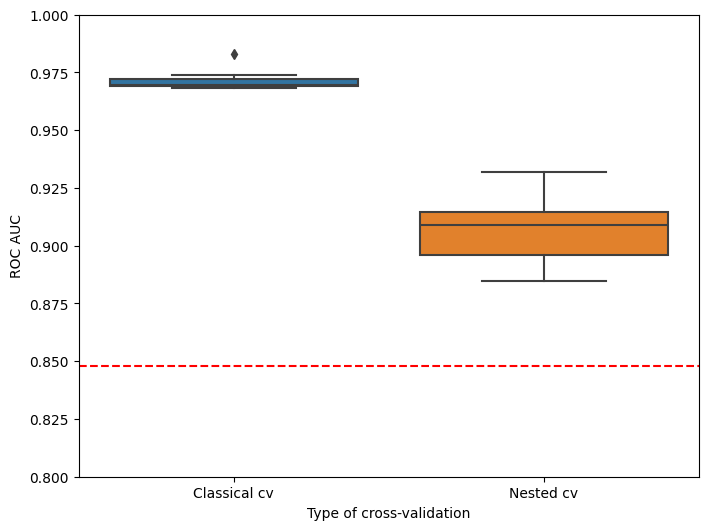

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine the lists into a DataFrame with category labels
results = pd.DataFrame({
    'roc_auc': perf_classical_cv + perf_nested_cv,
    'Type cv': ['Classical cv'] * len(perf_classical_cv) + ['Nested cv'] * len(perf_nested_cv)
})

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Type cv', y='roc_auc', data=results)

# Customize the plot
plt.hlines(lr_perf, -0.5, 1.5, colors='red', linestyles='dashed')
plt.xlabel('Type of cross-validation')
plt.ylabel('ROC AUC')
plt.ylim(0.80, 1.0)

### How to train our final model?

In [14]:
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=params_grid,
    scoring="roc_auc",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    n_jobs=-1,
)
grid_search.fit(X, y)

final_model = grid_search.best_estimator_
final_model

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### `Pipeline` object

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("model", xgb.XGBClassifier()),
    ]
)

params_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.1, 0.5],
}

### Nested CV with scaled data

In [16]:
perf_nested_cv_scaled = []

for i in range(n_trials):
    perf_outer = []
    splitter = StratifiedKFold(n_splits=5, random_state=i, shuffle=True)
    # splits the data into training and testing sets
    for train_index, test_index in splitter.split(X, y):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]

        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=params_grid,
            scoring="roc_auc",
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=i),
            n_jobs=-1,
        )
        grid_search.fit(X_train, y_train)

        y_pred = grid_search.predict(X_test)
        perf_outer.append(roc_auc_score(y_test, y_pred))
    perf_nested_cv_scaled.append(np.mean(perf_outer))

Text(0, 0.5, 'ROC AUC')

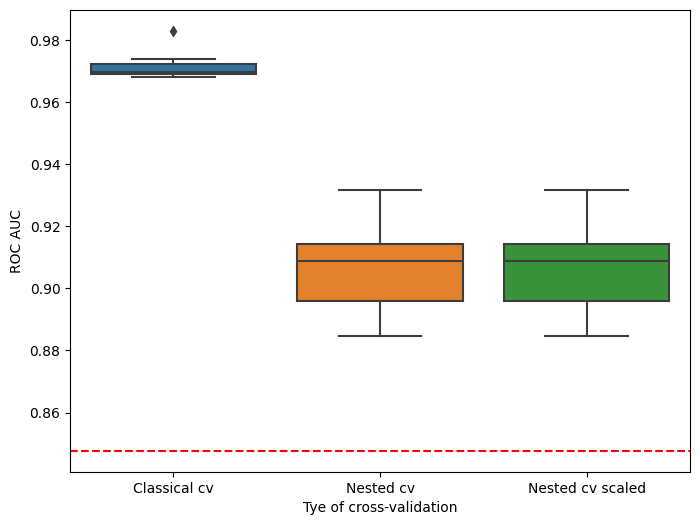

In [17]:
# Combine the lists into a DataFrame with category labels
results = pd.DataFrame({
    'roc_auc': perf_classical_cv + perf_nested_cv + perf_nested_cv_scaled,
    'Type cv': ['Classical cv'] * len(perf_classical_cv) + ['Nested cv'] * len(perf_nested_cv) + ['Nested cv scaled'] * len(perf_nested_cv_scaled)
})

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Type cv', y='roc_auc', data=results)

# Customize the plot
plt.hlines(lr_perf, -0.5, 2.5, colors='red', linestyles='dashed')
plt.xlabel('Tye of cross-validation')
plt.ylabel('ROC AUC')

### Nested CV with PCA

In [18]:
from sklearn.decomposition import PCA

pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("model", xgb.XGBClassifier()),
    ]
)

params_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.1, 0.5],
    "pca__n_components": [2, 3, 5],
}

In [19]:
perf_nested_cv_pca = []

for i in range(n_trials):
    perf_outer = []
    splitter = StratifiedKFold(n_splits=5, random_state=i, shuffle=True)
    # splits the data into training and testing sets
    for train_index, test_index in splitter.split(X, y):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]

        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=params_grid,
            scoring="roc_auc",
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=i),
            n_jobs=-1,
        )
        grid_search.fit(X_train, y_train)

        y_pred = grid_search.predict(X_test)
        perf_outer.append(roc_auc_score(y_test, y_pred))
    perf_nested_cv_pca.append(np.mean(perf_outer))

Text(0, 0.5, 'ROC AUC')

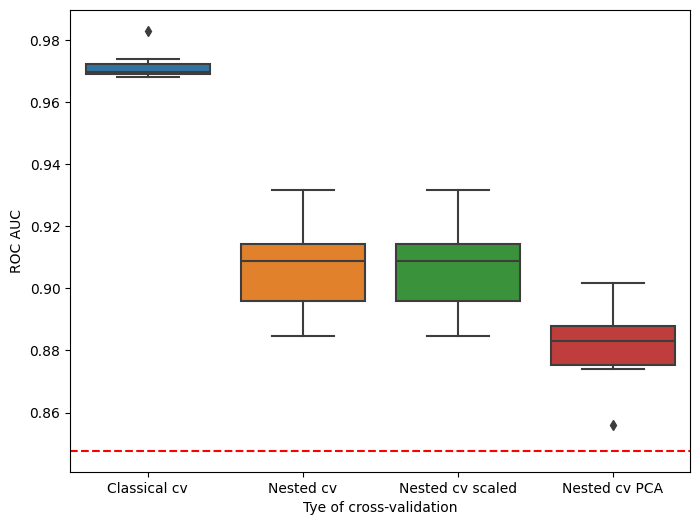

In [20]:
# Combine the lists into a DataFrame with category labels
results = pd.DataFrame({
    'roc_auc': perf_classical_cv + perf_nested_cv + perf_nested_cv_scaled + perf_nested_cv_pca,
    'Type cv': ['Classical cv'] * len(perf_classical_cv) + ['Nested cv'] * len(perf_nested_cv) + ['Nested cv scaled'] * len(perf_nested_cv_scaled) + ['Nested cv PCA'] * len(perf_nested_cv_pca)
})

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Type cv', y='roc_auc', data=results)

# Customize the plot
plt.hlines(lr_perf, -0.5, 3.5, colors='red', linestyles='dashed')
plt.xlabel('Tye of cross-validation')
plt.ylabel('ROC AUC')

### Nested CV with feature selection

In [21]:
from sklearn.feature_selection import SelectKBest
pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        # measure association between eahc variable and the target
        ("selector", SelectKBest()),
        ("model", xgb.XGBClassifier()),
    ]
)

params_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.1, 0.5],
    "selector__k": [10, 20, 30]
}

In [22]:
perf_nested_cv_feature = []

for i in range(n_trials):
    perf_outer = []
    splitter = StratifiedKFold(n_splits=5, random_state=i, shuffle=True)
    # splits the data into training and testing sets
    for train_index, test_index in splitter.split(X, y):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]

        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=params_grid,
            scoring="roc_auc",
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=i),
            n_jobs=-1,
        )
        grid_search.fit(X_train, y_train)

        y_pred = grid_search.predict(X_test)
        perf_outer.append(roc_auc_score(y_test, y_pred))
    perf_nested_cv_feature.append(np.mean(perf_outer))

Text(0, 0.5, 'ROC AUC')

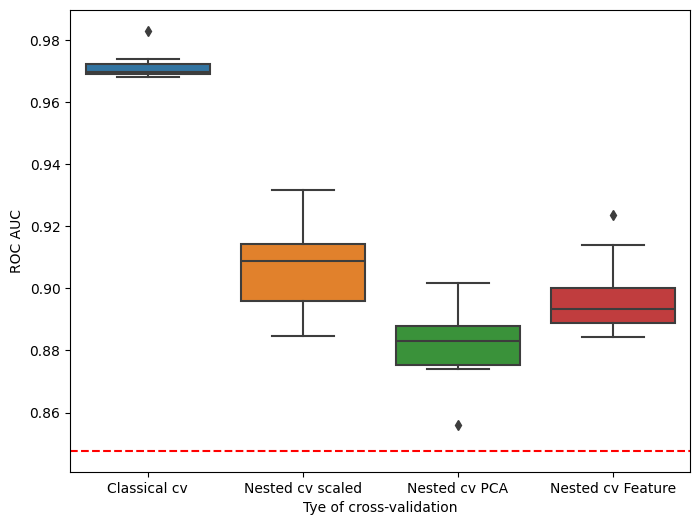

In [23]:
# Combine the lists into a DataFrame with category labels
results = pd.DataFrame({
    'roc_auc': perf_classical_cv + perf_nested_cv_scaled + perf_nested_cv_pca + perf_nested_cv_feature,
    'Type cv': ['Classical cv'] * len(perf_classical_cv) + ['Nested cv scaled'] * len(perf_nested_cv_scaled) + ['Nested cv PCA'] * len(perf_nested_cv_pca) + ['Nested cv Feature'] * len(perf_nested_cv_feature)
})

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Type cv', y='roc_auc', data=results)

# Customize the plot
plt.hlines(lr_perf, -0.5, 3.5, colors='red', linestyles='dashed')
plt.xlabel('Tye of cross-validation')
plt.ylabel('ROC AUC')

### Benchmarking with other models

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

params_grid = {
    "logistic_regression": {
        "model__C": [0.01, 0.1, 1, 10],
    },
    "random_forest": {
        "model__n_estimators": [50, 100, 200],
        "model__max_depth": [3, 5, 7],
    },
    "xgboost": {
        "model__n_estimators": [50, 100, 200],
        "model__max_depth": [3, 5, 7],
        "model__learning_rate": [0.01, 0.1, 0.5],
    },
    "knn": {
        "model__n_neighbors": [3, 5, 7],
    },
}

dict_models = {
    "logistic_regression": LogisticRegression(),
    "random_forest": RandomForestClassifier(),
    "xgboost": xgb.XGBClassifier(),
    "knn": KNeighborsClassifier(),
}


perf_nested_cv_all = {
    "logistic_regression": [],
    "random_forest": [],
    "xgboost": [],
    "knn": [],
}

In [25]:
for i in range(n_trials):
    splitter = StratifiedKFold(n_splits=5, random_state=i, shuffle=True)
    # splits the data into training and testing sets
    for train_index, test_index in splitter.split(X, y):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]

        for model_name, model in dict_models.items():
            pipeline = Pipeline(
                steps=[
                    ("scaler", StandardScaler()),
                    ("model", model),
                ]
            )

            grid_search = GridSearchCV(
                estimator=pipeline,
                param_grid=params_grid[model_name],
                scoring="roc_auc",
                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=i),
                n_jobs=-1,
            )
            grid_search.fit(X_train, y_train)

            y_pred = grid_search.predict(X_test)
            perf_nested_cv_all[model_name].append(roc_auc_score(y_test, y_pred))

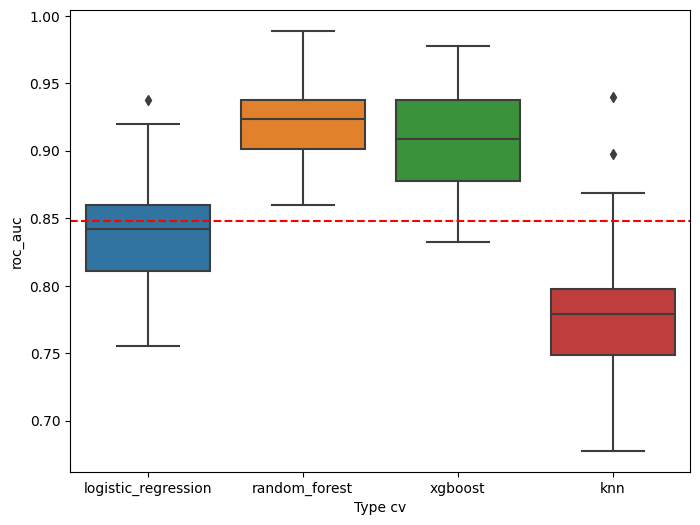

In [26]:
# Combine the lists into a DataFrame with category labels

list_metrics = []
list_names_models = []
for model_name, metrics in perf_nested_cv_all.items():
    list_metrics += metrics
    list_names_models += [model_name] * len(metrics)

results = pd.DataFrame({
    'roc_auc': list_metrics,
    'Type cv': list_names_models 
})

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Type cv', y='roc_auc', data=results)
plt.hlines(lr_perf, -0.5, 3.5, colors='red', linestyles='dashed')
plt.show()